#Imports

In [1]:
#imports related to RAM and GPU size config
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import GPUtil as GPU

In [2]:
import gc #garbage collector to release memory
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

#import related to data handling & visulization
from itertools import product
import time
from tqdm import tqdm
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", 11)
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
sns.set(style="darkgrid")

#imports related to preprocessing and feature engineering
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

#imports related to modelization
import gc
from xgboost import XGBRegressor, plot_importance

#Constants

In [3]:
file_paths=["./items.csv", "./shops.csv", "./item_categories.csv", "./sales_train.csv", "./test.csv"]
file_names=["items", "shops", "cats", "train", "test"]
STORE_SUBMISSION=True
MODEL_PARAMS = {
    "model_init": {"max_depth":10,
                  "n_estimators":1000,
                  "min_child_weight":0.5, 
                  "colsample_bytree":0.8, 
                  "subsample":0.8, 
                  "eta":0.1,
                  "objective":'reg:squarederror',
                  "tree_method":'gpu_hist',
                  "seed":42
    },
    "model_fit":  {"eval_metric":"rmse", 
                  "verbose":True, 
                  "early_stopping_rounds":20
    }
}

#Useful functions


In [4]:
#print available RAM size
def print_RAM():
  '''
  This function allows to print the available GPU RAM
  '''
  try:
    gpu = GPU.getGPUs()[0]
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  except:
    print("No GPU found, don't forget to activate GPU accelerator if you're on Colab")

In [5]:
# load data function
def load_data(list_of_file_paths, list_of_file_names):
    '''
    INPUTS:
      - list_of_file_paths: list of file's paths
      - list_of_file_names: list of file's names
    OUTPUT:
      - returns a dictionnary with keys as name files, and values as dataframes
    '''
    data=[]
    for file_path in list_of_file_paths:
        data.append(pd.read_csv(file_path))
    return dict(zip(list_of_file_names, data))

In [6]:
# correct shop, item names function
def name_correction(name:str) -> str:
  '''
  INPUTS:
    - a string name to be processed
  OUTPUT:
    - returns a processed name after removal of special characters and double spaces
  '''
  name = name.lower() # all letters lower case
  name = name.partition('[')[0] # partition by square brackets
  name = name.partition('(')[0] # partition by curly brackets
  name = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', name) # remove special characters
  name = name.replace('  ', ' ') # replace double spaces with single spaces
  name = name.strip() # remove leading and trailing white space
  return name

In [7]:
# Define a lag feature function
def lag_feature(df:pd.DataFrame, lags:list, cols:list) -> pd.DataFrame:
  '''
  INPUTS:
    - a dataframe containing the columns to be lagged
    - a list of number of lags to be affected to columns
    - a list of column names to be lagged
  OUTPUT:
    - returns the same dataframe with extra columns of shifted values
  '''
  for col in cols:
      tmp = df[["date_block_num", "shop_id","item_id",col ]]
      for i in lags:
          shifted = tmp.copy()
          shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
          shifted.date_block_num = shifted.date_block_num + i
          df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
  return df

In [8]:
#define a feature engineering function to add lags grouped by certain columns given as a parameter
def adding_lag_feature(matrix:pd.DataFrame,group_by_columns:list,lag_column_name:list,agg_column:str,lags:list)->pd.DataFrame:
  '''
  INPUTS:
    - a dataframe containing all the features
    - a list of column names to group by
    - a list of column names to lag
    - a list of column names to aggregate
    - a list of number of lags to be affected to columns
  OUTPUT:
    - returns the feature matrix with added shifted values by group columns
  '''
  group = matrix.groupby( group_by_columns ).agg({agg_column : ["mean"]})
  group.columns = lag_column_name
  group.reset_index(inplace = True)

  matrix = pd.merge(matrix, group, on=group_by_columns, how="left")
  matrix[lag_column_name[0]] = matrix[lag_column_name[0]].astype(np.float16)
  matrix = lag_feature( matrix, lags, lag_column_name )
  matrix.drop(lag_column_name, axis=1, inplace=True )

  return matrix

In [9]:
def select_trends(row, lags:list=[1,2,3]) :
  '''
  INPUTS:
    - a dataframe containing the lagged delta prices
    - a list of number of lags to be affected to columns
  OUTPUT:
    - returns either the row or False
  '''
  for i in lags:
    if row["delta_price_lag_" + str(i)]:
        return row["delta_price_lag_" + str(i)]
  return 0

In [10]:
# Cramers'V (Similar to correlation factor but for Categorical Data)
def cramers_v(x, y):
    '''
    INPUTS:
    - a first array containing categorical values
    - a second array containing categorical values
    - 
    OUTPUT:
    - returns a Cramer's V test value
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [11]:
# Remove Outliers
def reject_outliers(data, m = 2.):
    '''
    INPUTS:
    - a dataframe
    - an int specifying threshold 
    - 
    OUTPUT:
    - a datafram without outliers
    '''
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

#Main

##Data Exploration

###Data Loading

In [12]:
#load all data in dict of dataframes
data = load_data(file_paths, file_names)

In [13]:
data['train'].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [14]:
data['items'].head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [15]:
data['shops'].head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [16]:
data['cats'].head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


### Data Pre-analysis

0it [00:00, ?it/s]

error date


6it [01:11, 11.89s/it]


Text(0.5, 0.98, 'Plotting Distribution of the dataset \n  ')

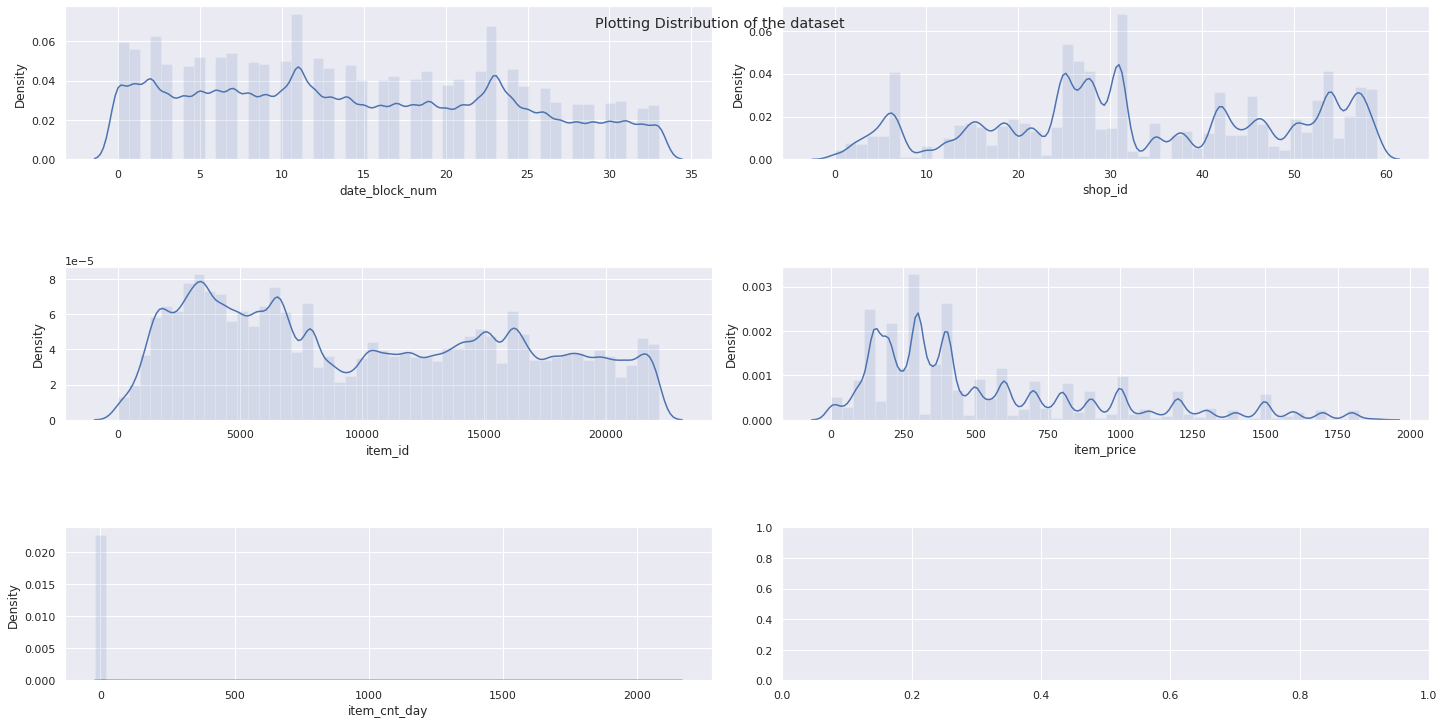

In [17]:
# plotting distributions
x = data['train']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 10))

index = 0
axs = axs.flatten()

for k,v in tqdm(data['train'].items()):
    try:
      if k=='item_price':
        temp_x = reject_outliers(x['item_price'], m = 6.)
        sns.distplot(temp_x, ax=axs[index], hist_kws={"color" :"b", "alpha": 0.15})
      else:
        sns.distplot(x[k], ax=axs[index], hist_kws={"color" :"b", "alpha": 0.15})
      index += 1

    except:
      print('error {}'.format(k))


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.suptitle('Plotting Distribution of the dataset \n  ')

100%|██████████| 6/6 [03:01<00:00, 30.26s/it]


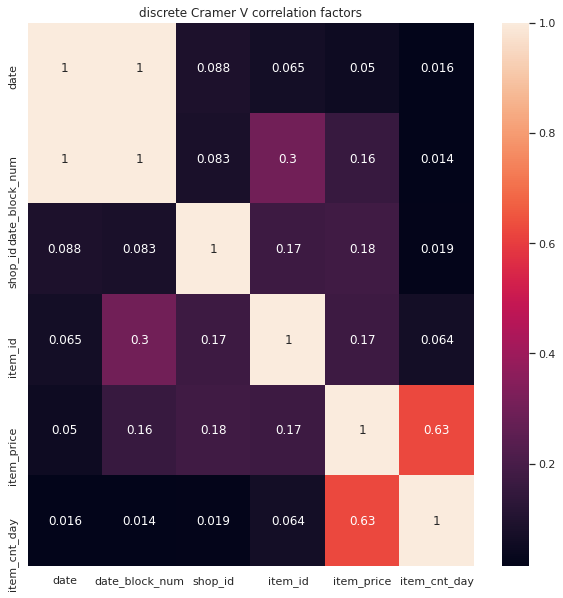

In [18]:
# Correlation Matrix
df = data['train'].sample(frac=0.5)
corrMat = np.zeros((len(df.columns), len(df.columns)))
for i in tqdm(range(len(df.columns))):
  for j in range(len(df.columns)):
    corrMat[i,j] = cramers_v(df[df.columns[i]],df[df.columns[j]])

plt.figure(figsize=(10,10))
plt.subplot(111)
plt.title('discrete Cramer V correlation factors')
sns.heatmap(np.abs(corrMat), xticklabels=list(df.columns), yticklabels=list(df.columns), annot=True)

In [19]:
del corrMat
gc.collect()

87

## Pre-processing


###Cleaning Sales Data

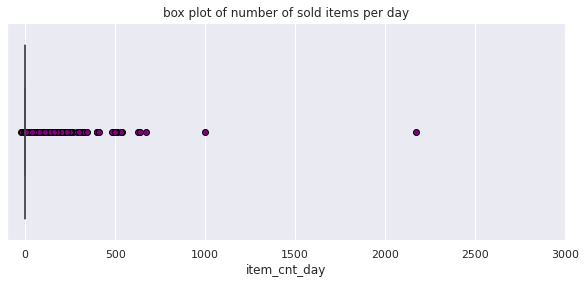

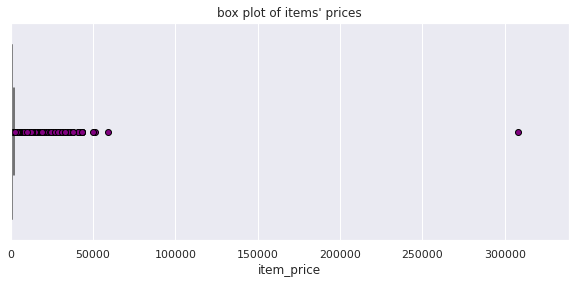

In [20]:
# define plotting params
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')

#plot box plot of number of sold items per day
plt.figure(figsize=(10,4))
plt.title("box plot of number of sold items per day")
plt.xlim(-100, 3000)
sns.boxplot(x=data["train"].item_cnt_day, flierprops=flierprops)
plt.show()

#plot box plot of items' prices
plt.figure(figsize=(10,4))
plt.title("box plot of items' prices")
plt.xlim(data["train"].item_price.min(), data["train"].item_price.max()*1.1)
sns.boxplot(x=data["train"].item_price, flierprops=flierprops)
plt.show()

**we detect outliers in both plots so they need to be removed and therefore we define a threshold for item's price so that it's > 0 and < 100000 and a threshold for item's count per day so that it's < 1000. Besides, we notice that some item counts per day are negative (probably returned items) and in order to make the problem easier, we will only handle positive integers therefore we set the minimum to 0**

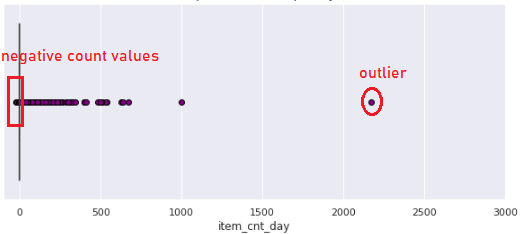

**Conclusion:**

- item_cnt_day contains outliers. 
- item_cnt_day has negative values.
- item_price has null values.
- item_price has outliers.
- All these problems will be dealt with in further steps.

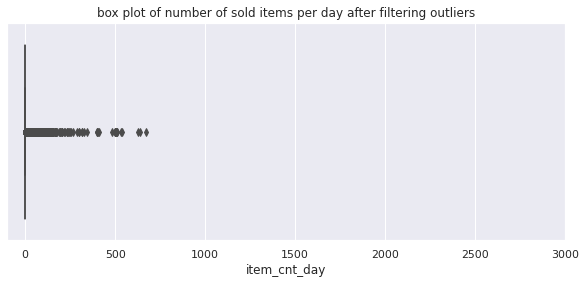

In [21]:
# filtering outliers and keeping only >=0 values for items' count per day
min_item_price, max_item_price, max_item_cnt=0,100000,1000
data["train"].loc[data["train"].item_cnt_day < 1, "item_cnt_day"] = 0
data["train"] = data["train"][(data["train"].item_price < max_item_price )&(data["train"].item_price > min_item_price)&(data["train"].item_cnt_day < max_item_cnt)].reset_index(drop = True)

#plot box plot of sold items per day after filter
plt.figure(figsize=(10,4))
plt.title("box plot of number of sold items per day after filtering outliers")
plt.xlim(-100, 3000)
sns.boxplot(x=data["train"].item_cnt_day)#, flierprops=flierprops)
plt.show()

### Cleaning Shop Data

In [22]:
#redundent shop names
data["shops"].iloc[[0,57,1,58,10,11]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


**Feature exploration**:

* **shop_name**: shop name.
* **shop_id**: .shop unique id.

**we notice the existence of duplicates and typos in shop names**

In [23]:
data["shops"].shop_name = data["shops"].shop_name.apply(lambda x:name_correction(x)) #remove typos from shop names
#fix duplicate for both train and test datasets
data["train"].loc[data["train"].shop_id == 0, 'shop_id'] = 57; data["test"].loc[data["test"].shop_id == 0, 'shop_id'] = 57;
data["train"].loc[data["train"].shop_id == 1, 'shop_id'] = 58;data["test"].loc[data["test"].shop_id == 1, 'shop_id'] = 58;
data["train"].loc[data["train"].shop_id == 10, 'shop_id'] = 11; data["test"].loc[data["test"].shop_id == 10, 'shop_id'] = 11;

**We notice that:**:

* ```shop_name``` follow this pattern city, category.
* Example:
    * ```Якутск Орджоникидзе, 56 фран``` --> ```Yakutsk Ordzhonikidze(city), 56 francs (category)```
    * ```Балашиха ТРК "Октябрь-Киномир"```	--> ```Balashikha(city) TRK(category) "October-Kinomir"```
    
* Thus, we must extract name and category from the ```shop_name``` column because consumption behaviours depend on the city (rural Vs urban).

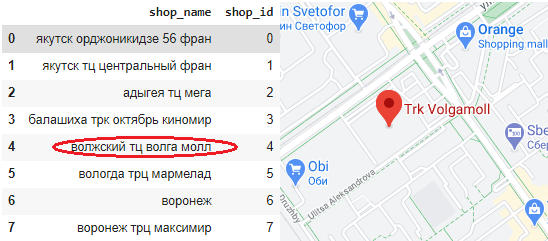


In [24]:
data["shops"].loc[ data["shops"].shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"' #a special case that need to be handled manually 
#we split the shop name and get the first word as city, the second word as shop category and neglect the rest
data["shops"]["shop_city"] = data["shops"].shop_name.str.split(" ").map( lambda x: x[0] if(len(x) > 0) else "")
data["shops"]["shop_category"] = data["shops"].shop_name.str.split(" ").map( lambda x: x[1] if(len(x) > 1) else "")

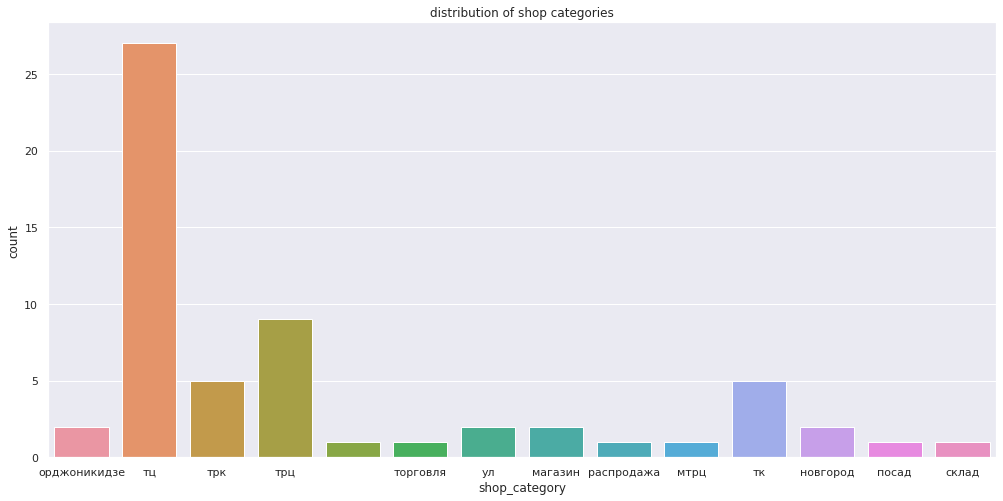

In [25]:
plt.figure(figsize=(17,8))
plt.title("distribution of shop categories")
sns.countplot(data=data["shops"], x="shop_category")
plt.show()

**Conclusions:**
* The most frequent category is ```ТЦ```.
* The most infrequent categories are ```ул, Орджоникидзе, Распродажа, C, ЧС, Магазин, Торговля, МТРЦ, Плехановская, склад```
* In order to reduce the number of categories, we must group the infrequent categories into the same category.

In [26]:
shop_categories, shop_categories_threshold = [], 5
for cat in data["shops"].shop_category.unique():
    if len(data["shops"][data["shops"].shop_category == cat]) >= shop_categories_threshold:
        shop_categories.append(cat)
data["shops"].shop_category = data["shops"].shop_category.apply( lambda x: x if (x in shop_categories) else "other")
print(f"the list of shop categories is : {data['shops'].shop_category.unique()}")

the list of shop categories is : ['other' 'тц' 'трк' 'трц' 'тк']


In [27]:
#encode both shop categories and cities
data["shops"]["shop_category_encoded"] = LabelEncoder().fit_transform( data["shops"].shop_category )
data["shops"]["shop_city_encoded"] = LabelEncoder().fit_transform( data["shops"].shop_city)
data["shops"]= data["shops"][["shop_id", "shop_name", "shop_city", "shop_city_encoded", "shop_category", "shop_category_encoded"]]
data["shops"].head()

,shop_id,shop_name,shop_city,shop_city_encoded,shop_category,shop_category_encoded
0,0,якутск орджоникидзе 56 фран,якутск,29,other,0
1,1,якутск тц центральный фран,якутск,29,тц,4
2,2,адыгея тц мега,адыгея,0,тц,4
3,3,балашиха трк октябрь киномир,балашиха,1,трк,2
4,4,волжский тц волга молл,волжский,2,тц,4


### Cleaning Item Category Data




**we notice that item name is mainly composed out of 2 elements seperated generally by a - the first one is the type of the item (accessorie, game,etc) and the second term is a subtype i.e a more specific description of the item name**

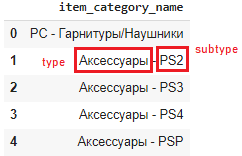

**Conclusions**:
* ```item_category_name``` follow this pattern ```type - subtype```.

In [28]:
data["cats"]["item_category_type"] = data["cats"].item_category_name.str.split(" ").map( lambda x: x[0] if(len(x) > 0) else "")
data["cats"].loc[ (data["cats"].item_category_type == "Игровые")| (data["cats"].item_category_type == "Аксессуары"), "item_category_type" ] = "Игры"

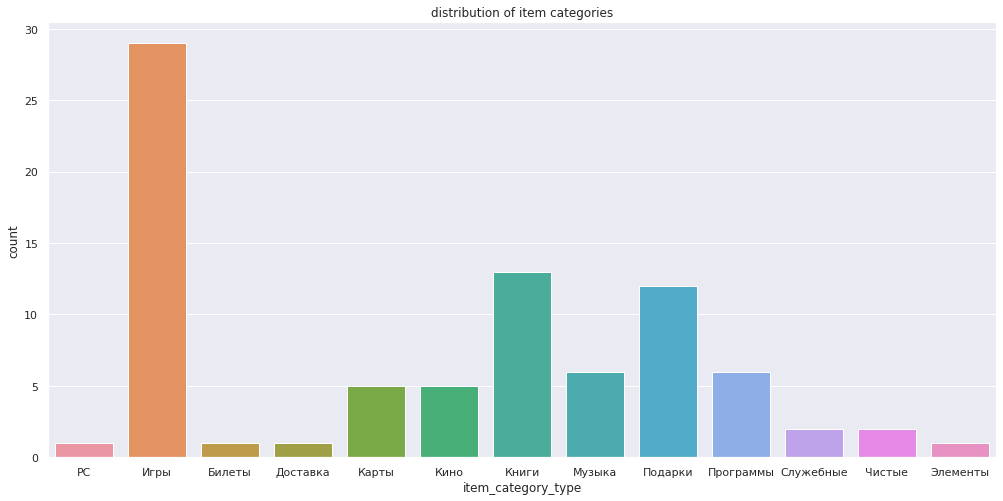

In [29]:
plt.figure(figsize=(17,8))
plt.title("distribution of item categories")
sns.countplot(data=data["cats"], x="item_category_type")
plt.show()

**we notice that many item categories have less than 5 occurrences so in order to avoid multiple unnecessary labels we will group those categories under a new one called "other"**

In [30]:
item_categories, item_categories_threshold = [], 5 
for cat in data["cats"].item_category_type.unique():
    if len(data["cats"][data["cats"].item_category_type == cat]) >= item_categories_threshold: 
        item_categories.append( cat )
data["cats"].item_category_type = data["cats"].item_category_type.apply(lambda x: x if (x in item_categories) else "other")
print(f"the list of item categories is : {data['cats'].item_category_type.unique()}")

the list of item categories is : ['other' 'Игры' 'Карты' 'Кино' 'Книги' 'Музыка' 'Подарки' 'Программы']


In [31]:
data["cats"]["item_category_type_encoded"] = LabelEncoder().fit_transform(data["cats"].item_category_type)
data["cats"]["item_category_subtype"] = data["cats"].item_category_name.str.split("-").map(lambda x: x[1].strip() if(len(x) > 1) else(x[0].strip() if(len(x) > 0) else ""))
data["cats"]["item_category_subtype_encoded"] = LabelEncoder().fit_transform( data["cats"]["item_category_subtype"] )
data["cats"] = data["cats"][["item_category_id", "item_category_name", "item_category_type", "item_category_type_encoded", "item_category_subtype", "item_category_subtype_encoded"]]
data["cats"].head()

,item_category_id,item_category_name,item_category_type,item_category_type_encoded,item_category_subtype,item_category_subtype_encoded
0,0,PC - Гарнитуры/Наушники,other,0,Гарнитуры/Наушники,29
1,1,Аксессуары - PS2,Игры,1,PS2,9
2,2,Аксессуары - PS3,Игры,1,PS3,10
3,3,Аксессуары - PS4,Игры,1,PS4,11
4,4,Аксессуары - PSP,Игры,1,PSP,13


###Cleaning Item Data


In [32]:
data["items"].item_name

0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1        !ABBYY FineReader 12 Professional Edition Full...
2            ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3          ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4              ***КОРОБКА (СТЕКЛО)                       D
                               ...                        
22165               Ядерный титбит 2 [PC, Цифровая версия]
22166      Язык запросов 1С:Предприятия  [Цифровая версия]
22167    Язык запросов 1С:Предприятия 8 (+CD). Хрустале...
22168                                  Яйцо для Little Inu
22169                        Яйцо дракона (Игра престолов)
Name: item_name, Length: 22170, dtype: object

**conclusions**:
* the ```item_name``` follow these patterns ```name (details)``` and ```name [details]```.
* For example: 
    * ```ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D``` (russian language) <--> ```IN THE POWER OF NAVIGATION (PLAST.) D``` in English.
    * ```007 Legends [PS3, русская версия]``` (russian language) <--> ```007 Legends [PS3 Russian Version]``` in English.
* Thus, we must extract these fields from ```item_name``` and try to categorize items using those details.

In [33]:
data["items"]["item_name_details"] = data["items"].item_name.apply(lambda x:re.split("\(|\[",x)[1] if(len(re.split("\(|\[",x))>1) else "" )
data["items"].item_name = data["items"].item_name.apply(lambda x: name_correction(x))
data["items"].item_name_details = data["items"].item_name_details.apply(lambda x: name_correction(x))

In [34]:
data["items"]["item_types"] = data["items"].item_name_details.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
data["items"].loc[(data["items"].item_types == "x360") | (data["items"].item_types == "xbox360") | (data["items"].item_types == "xbox 360") ,"item_types"] = "xbox 360"

In [35]:
item_types, item_types_threshold = [], 100 
for type in data["items"].item_types.unique():
    if len(data["items"][data["items"].item_types == type]) >= item_types_threshold: 
        item_types.append(type)
data["items"].item_types = data["items"].item_types.apply(lambda x: x if (x in item_types) else "other")

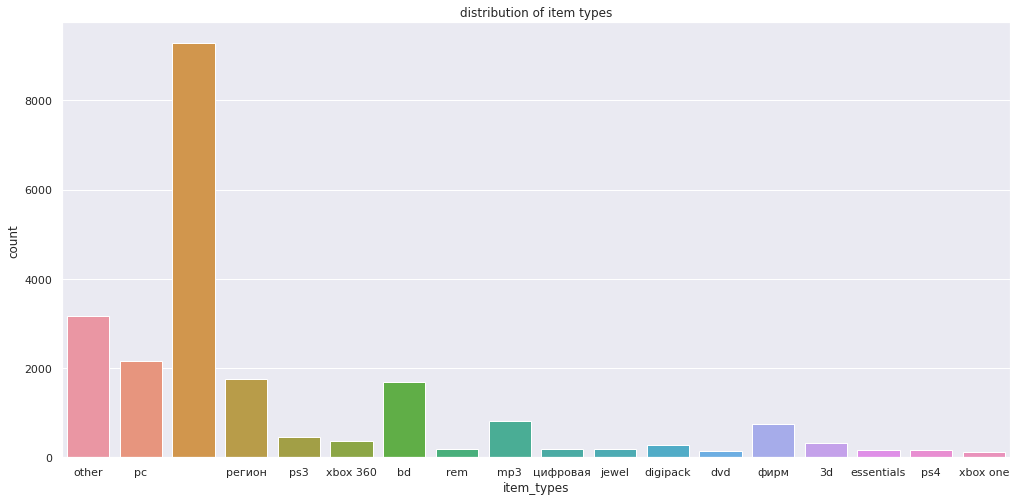

In [36]:
plt.figure(figsize=(17,8))
plt.title("distribution of item types")
sns.countplot(data=data["items"], x="item_types")
plt.show()

In [37]:
data["items"]["item_types_encoded"] = LabelEncoder().fit_transform(data["items"].item_types)
data["items"] = data["items"][["item_name", "item_id", "item_category_id", "item_types", "item_types_encoded"]]
data["items"].head()

,item_name,item_id,item_category_id,item_types,item_types_encoded
0,во власти наваждения,0,40,other,8
1,abbyy finereader 12 professional edition full,1,76,pc,9
2,в лучах славы,2,40,other,8
3,голубая волна,3,40,other,8
4,коробка,4,40,other,8


##Feature Engineering

### Gathering features in one giant matrix

In [38]:
#keeping only numerical columns for feature engineering
data["shops"]= data["shops"][["shop_id", "shop_city_encoded", "shop_category_encoded"]]
data["cats"] = data["cats"][["item_category_id", "item_category_type_encoded", "item_category_subtype_encoded"]]
data["items"] = data["items"][["item_id", "item_category_id", "item_types_encoded"]]

In [39]:
start = time.time()                                         ##
##############################################################

matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(round(data["train"].date_block_num.min()), round(data["train"].date_block_num.max()+1)):
    sales = data["train"][data["train"].date_block_num == i] #get shop_id and item_id product for each month
    matrix.append( np.array(list( product([i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

#controlling data types is crucial because of the estimated high memory volume of matrix dataframe
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8) 
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

# add revenue to train df:  revenue_day = item_cnt_day * item_price
data["train"]["revenue_day"] = data["train"]["item_cnt_day"] * data["train"]["item_price"]

#get MONTHLY count of sold items rather than DAILY
group = data["train"].groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)

#add test data of the 35th month to the matrix
data["test"]["date_block_num"] = 34
data["test"]["date_block_num"] = data["test"]["date_block_num"].astype(np.int8)
data["test"]["shop_id"] = data["test"].shop_id.astype(np.int8)
data["test"]["item_id"] = data["test"].item_id.astype(np.int16)
matrix = pd.concat([matrix, data["test"].drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )

#add shops, items data (categories, subcategories, cities etc...) and always control type
matrix = pd.merge( matrix, data["shops"], on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, data["items"], on = ["item_id"], how = "left")
matrix = pd.merge( matrix, data["cats"], on = ["item_category_id"], how = "left" )
matrix["shop_city_encoded"] = matrix["shop_city_encoded"].astype(np.int8)
matrix["shop_category_encoded"] = matrix["shop_category_encoded"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["item_category_type_encoded"] = matrix["item_category_type_encoded"].astype(np.int8)
matrix["item_category_subtype_encoded"] = matrix["item_category_subtype_encoded"].astype(np.int8)
matrix["item_types_encoded"] = matrix["item_types_encoded"].astype(np.int8)


#########################################################################################################################
time_sec=round(time.time()-start)                                                                                      ##
print(f"This step took {time_sec//60}M {time_sec%60}S {'while' if(len(GPU.getGPUs())>0) else 'without'} using GPU")    ##
matrix.head()                                                                                                          ##

This step took 0M 22S while using GPU


,date_block_num,shop_id,item_id,item_cnt_month,shop_city_encoded,shop_category_encoded,item_category_id,item_types_encoded,item_category_type_encoded,item_category_subtype_encoded
0,0,2,19,0.0,0,4,40,0,3,4
1,0,2,27,1.0,0,4,19,10,1,10
2,0,2,28,0.0,0,4,30,8,1,55
3,0,2,29,0.0,0,4,23,13,1,16
4,0,2,32,0.0,0,4,40,0,3,4


###Adding <u>Value features</u>

** *texte en italique*Value features contains the following columns:**


*   Grouped combinations of extracted data (city, category, sybcategory) aggregated on MONTHLY average sold items' count and their 3 months lagged values
*   The delta between average total item price and average MONTHLY item price for each lag out of the 3 months lag
*   The delta between average total shop revenue and average MONTHLY shop revenue lagged by one month

In fact, extracted elements such as the shop location, the category and subcategory of the item could affect heavily the number of pieces sold on a monthly basis. When a shop is located in an urban city it has higher sale rate than a one located in an urban ciy. Besides, some categories of items are sold more often than other. etc...

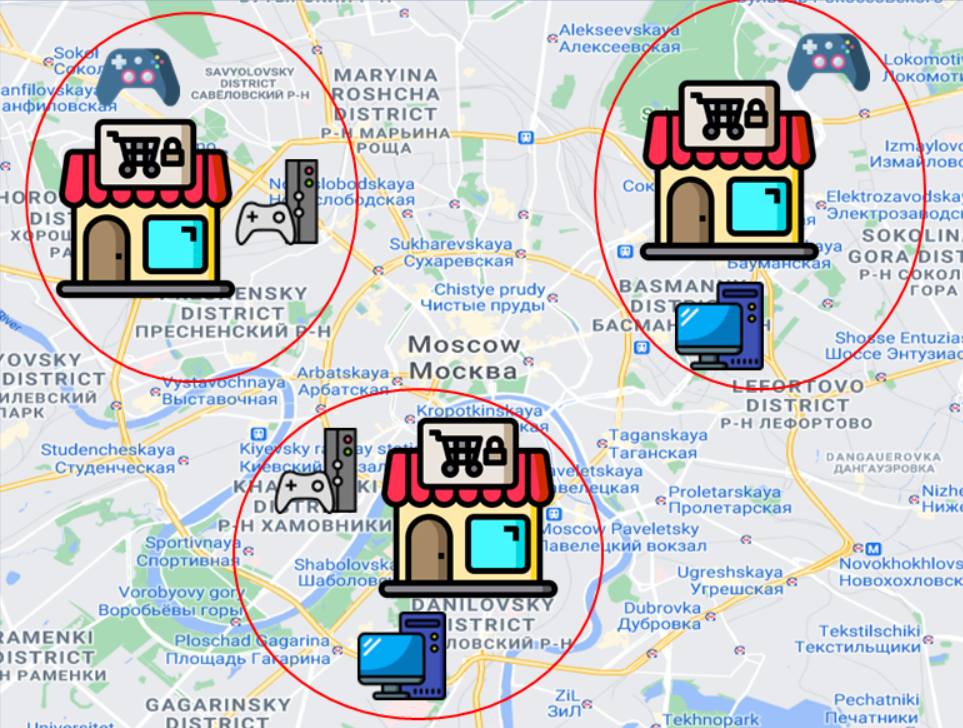

In [40]:
start = time.time()                                         ##
##############################################################



##### SOLD ITEMS COUNT FEATURES ########################

#add sold items count for last 3 months
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )

#add average total sold items count of last month
matrix=adding_lag_feature(matrix,["date_block_num"],["date_avg_item_cnt"],"item_cnt_month",[1])

#add average sold item count of last 3 months per item for different shops
matrix=adding_lag_feature(matrix,["date_block_num", "item_id"],["date_item_avg_item_cnt"],"item_cnt_month",[1,2,3])

#add average sold item count of last 3 months per shop for different items
matrix=adding_lag_feature(matrix,["date_block_num","shop_id"],["date_shop_avg_item_cnt"],"item_cnt_month",[1,2,3])

#add average sold item count of last 3 months per item and per shop
matrix=adding_lag_feature(matrix,["date_block_num","shop_id","item_id"],["date_shop_item_avg_item_cnt"],"item_cnt_month",[1,2,3])

#add average sold item count of last month per shop and per subtype_code
matrix=adding_lag_feature(matrix,["date_block_num", "shop_id", "item_category_subtype_encoded"],["date_shop_subtype_avg_item_cnt"],"item_cnt_month",[1])

#add average sold item count of last month per shop city
matrix=adding_lag_feature(matrix,["date_block_num", "shop_city_encoded"],["date_city_avg_item_cnt"],"item_cnt_month",[1])

#add average sold item count of last month per per item and shop city
matrix=adding_lag_feature(matrix,["date_block_num", "item_id", "shop_city_encoded"],["date_item_city_avg_item_cnt"],"item_cnt_month",[1])



#####  ITEM PRICE FEATURES ########################

#add average sold items price in all dataset per item_id
group = data["train"].groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)
matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix.item_avg_item_price = matrix.item_avg_item_price.astype(np.float16)

#add average sold items MONTHLY price per item_id
group = data["train"].groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)
matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
#add 3 months lags of MONTHLY price
matrix = lag_feature( matrix, [1,2,3], ["date_item_avg_item_price"] )
for i in [1,2,3]:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]
#add delta between average total item price and average MONTHLY item price for each lag out of the 3 months lag
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
#keep only "delta_price_lag" feature
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in [1,2,3]:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)



#####  SHOP REVENUE FEATURES ########################

#add average MONTHLY shop revenue
group = data["train"].groupby( ["date_block_num","shop_id"] ).agg({"revenue_day": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)
matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

#add average total shop revenue
group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )
matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
#add delta between average total shop revenue and average MONTHLY shop revenue
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)
#add 1 month lag of the delta revenue 
matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
#keep only "delta_revenue_lag_1" feature
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)


##########################################################################################################################################
time_sec=round(time.time()-start)                                                                                                       ##
print(f"Value Features' engineering took {time_sec//60}M {time_sec%60}S {'while' if(len(GPU.getGPUs())>0) else 'without'} using GPU")   ##
matrix.iloc[round(2e6+1):round(2e6+5)]                                                                                                  ##

Value Features' engineering took 5M 15S while using GPU


,date_block_num,shop_id,item_id,item_cnt_month,shop_city_encoded,...,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
2000001,5,21,478,0.0,13,...,0.565430,0.424316,0.363525,-0.042542,56421.425781
2000002,5,21,479,0.0,13,...,0.086426,0.424316,0.000000,0.017014,56421.425781
2000003,5,21,481,0.0,13,...,0.086426,0.424316,0.181763,0.006866,56421.425781
2000004,5,21,482,1.0,13,...,0.565430,0.424316,3.181641,-0.021667,56421.425781


###Adding <u>Time features</u>

**Time features contains the following columns:**


*   The number of days of the month in question because a longer month has in general (not always) a higher sale rate
*   The month corresponding to the first time an item was sold because for example an item that has been introduced recently might have low to mild sale rate



In [41]:
start = time.time()                                         ##
##############################################################

#add the number of days of the month in question
nb_days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]

matrix["nb_days_per_month"] = matrix["date_block_num"] % 12 - 1
matrix["nb_days_per_month"] = matrix["nb_days_per_month"].apply(lambda x:nb_days_per_month[x]).astype(np.int8)

#add the month correspodning to the first time an item was sold (in our relative dataset) per item_id and per shop_id
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

matrix = matrix[matrix["date_block_num"] > 3] #remove the data of first 3 months because they're are meaningless due to the lagging
matrix.fillna( 0 ,inplace = True) #replace NaN with 0


#delete data since we don't need it anymore
del data
gc.collect()

##########################################################################################################################################
time_sec=round(time.time()-start)                                                                                                       ##
print(f"Time Features' engineering took {time_sec//60}M {time_sec%60}S {'with' if(len(GPU.getGPUs())>0) else 'without'} using GPU")     ##
matrix.iloc[round(2e6+1):round(2e6+5)]                                                                                                  ##

Time Features' engineering took 0M 8S with using GPU


,date_block_num,shop_id,item_id,item_cnt_month,shop_city_encoded,...,delta_price_lag,delta_revenue_lag_1,nb_days_per_month,item_shop_first_sale,item_first_sale
3497466,9,21,10980,0.0,13,...,0.045624,125132.695312,30,9,9
3497467,9,21,10985,0.0,13,...,0.010231,125132.695312,30,4,4
3497468,9,21,10986,0.0,13,...,0.023315,125132.695312,30,4,4
3497469,9,21,10987,0.0,13,...,0.209473,125132.695312,30,4,4


## Modelization 

In [42]:
matrix[matrix.date_block_num == 34].item_id

10913804     5037
10913805     5320
10913806     5233
10913807     5232
10913808     5268
            ...  
11127999    18454
11128000    16188
11128001    15757
11128002    19648
11128003      969
Name: item_id, Length: 214200, dtype: int16

###Data split (Train/Validation/Test)

In [43]:
target_name = 'item_cnt_month'
features_names = [column for column in matrix.columns if column != target_name]
#get first 33 months as training dataset
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1).values
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month'].values
#get 34th month as validation dataset
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1).values
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month'].values
#get 35th month features to be predicted for the submission file
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1).values
#prepare the submission dataframe with test IDs
submission = pd.DataFrame({
    "ID":matrix[matrix.date_block_num == 34].item_id
})
submission.reset_index(drop=True,inplace=True)

#delete matrix since we don't need it anymore
del matrix
gc.collect();

In [44]:
print_RAM()

No GPU found, don't forget to activate GPU accelerator if you're on Colab


###Model Fitting

In [45]:
start = time.time()                                               ##
####################################################################

#init a XGBregressor model
model = XGBRegressor(feature_names=features_names, **MODEL_PARAMS["model_init"])
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1,
             feature_names=['date_block_num', 'shop_id', 'item_id',
                            'shop_city_encoded', 'shop_category_encoded',
                            'item_category_id', 'item_types_encoded',
                            'item_category_type_encoded',
                            'item_category_subtype_encoded',
                            'item_cnt_month_lag_1', 'item_cnt_month_l...
                            'nb_days_per_month', 'item_shop_first_sale',
                            'item_first_sale'],
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=0.5, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,


In [46]:
#fit the model
model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_valid, Y_valid)], 
    **MODEL_PARAMS["model_fit"])

#delete training and validation datasets since we don't need it anymore
del X_train, Y_train, X_valid, Y_valid
gc.collect()
###############################################################################################################################
time_sec=round(time.time()-start)                                                                                            ##
print(f"The fitting step took {time_sec//60}M {time_sec%60}S {'with' if(len(GPU.getGPUs())>0) else 'without'} using GPU")    ##

[0]	validation_0-rmse:2.57737
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:2.46397
[2]	validation_0-rmse:2.37148
[3]	validation_0-rmse:2.29681
[4]	validation_0-rmse:2.2207
[5]	validation_0-rmse:2.16418
[6]	validation_0-rmse:2.11381
[7]	validation_0-rmse:2.06419
[8]	validation_0-rmse:2.03257
[9]	validation_0-rmse:2.0014
[10]	validation_0-rmse:1.97661
[11]	validation_0-rmse:1.97597
[12]	validation_0-rmse:1.9652
[13]	validation_0-rmse:2.01423
[14]	validation_0-rmse:2.01048
[15]	validation_0-rmse:2.04358
[16]	validation_0-rmse:2.03501
[17]	validation_0-rmse:2.0326
[18]	validation_0-rmse:2.02876
[19]	validation_0-rmse:2.02652
[20]	validation_0-rmse:2.02317
[21]	validation_0-rmse:2.03747
[22]	validation_0-rmse:2.03293
[23]	validation_0-rmse:2.03146
[24]	validation_0-rmse:2.03143
[25]	validation_0-rmse:2.03831
[26]	validation_0-rmse:2.06396
[27]	validation_0-rmse:2.06634
[28]	validation_0-rmse:2.06866
[29]	validation_0-rmse:2.06388
[30]	validation_0-r

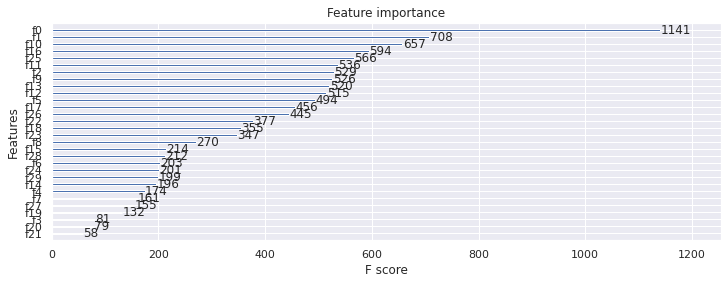

In [47]:
plot_importance(model)

###Prediction over TestSet & Score

In [48]:
#make predictions and store them in a csv file
Y_test = model.predict(X_test)
Y_test[Y_test < 0] = 0 
Y_test[Y_test > 20] = 20 #we have to clip values between 0 and 20 
assert len(Y_test) == len(submission), "must have same number of item_id and predictions"
submission["item_cnt_month"] = Y_test
submission.sort_values(by=['ID'], ascending=True, inplace=True, ignore_index=True)

if(STORE_SUBMISSION):
  submission.to_csv('submission.csv', index=False)
submission.head()

,ID,item_cnt_month
0,30,0.168980
1,30,0.148674
2,30,0.148674
3,30,0.182365
4,30,0.164873


**we got a best public score <u>0.86538</u> and we got ranked <u>313th</u> out of 10694 team**

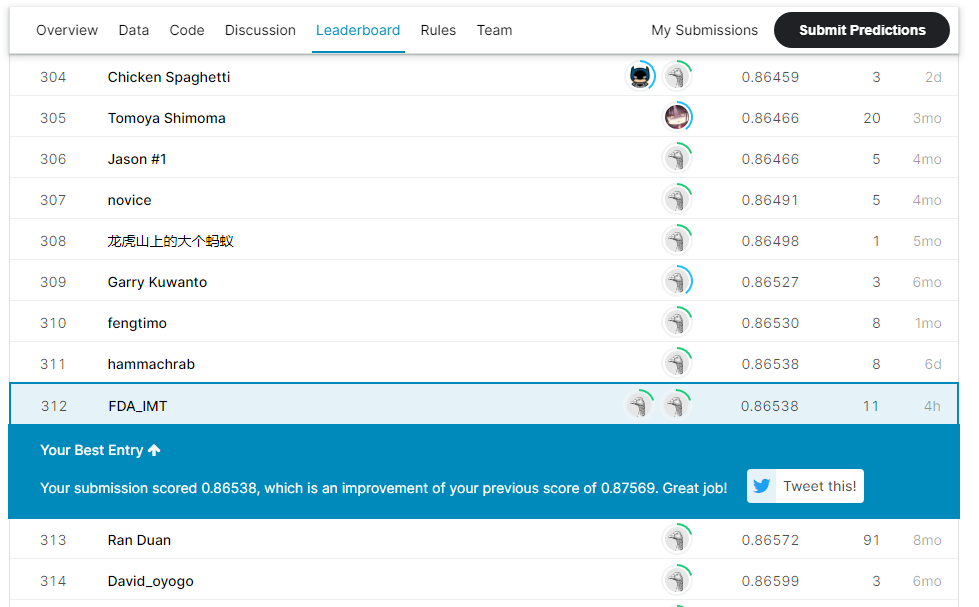